# Tarea 3 <br/> Redes Recurrentes <br/> CC6204 Deep Learning, Universidad de Chile 
## Nombre: Miguel Videla
Fecha de entrega: Jueves 30 de Agosto de 2018 <br/><br/>

En esta tarea **progamarás a mano** algunas arquitecturas de redes recurrentes. La idea es notar que son bastante simples de programar si se entienden los detalles. Esta vez utilizaremos el poder de PyTorch para que se encarge de crear el grafo de computación, calcular back-propagation (through-time para el caso de redes recurrentes) y usaremos optimizadores ya construidos para que el código de entrenamiento sea realmente fácil.

La tarea solo considera problemas sintéticos, más que nada para estar seguros de que las redes están bien programadas y son capaces de aprender problemas simples, y para poder comparar con un número arbitrario de datos el uso de distintas arquitecturas de redes. Hay  una parte opcional final en donde podrás usar tus propias redes para entrenarlas con datos reales, por ejemplo, para aprender y generar texto.

Hay poco tiempo para resolver la tarea, pero la cantidad de código que deben escribir es sumamente poca (para la primera parte no debieran ser más de 5 líneas!). Pero no la dejen para último minuto porque siempre hay detalles que los pueden atrasar.

**Las únicas partes que revisaremos serán las Partes 2 y 4**, el resto son opcionales. 

**IMPORTANTE**: Para avanzar rápido te recomendamos ir directamente a la Parte 2 y leer sólo lo que vayas necesitando de la Parte 1 (que son solo preliminares  para hacer tu tarea  más fácil). Si tienes poco tiempo la Parte 3 la puedes ignorar completamente (es una parte opcional solo para los más motivados).

Comenzamos instalando lo necesario y haciendo los imports de módulos que usaremos.


In [0]:
# Este notebook está pensado para correr en CoLaboratory. 
# Comenzamos instalando las librerías necesarias.
# Si lo estás ejecutando localmente posiblemente no sea necesario
# reinstalar todo.

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl
!pip install -q ipdb
!pip install -q git+https://github.com/google/sre_yield.git --upgrade

In [0]:
import torch
import numpy as np
import sys
import time
import ipdb
import math
import matplotlib.pyplot as plt
import sre_yield

from torch.nn import Parameter
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

if torch.cuda.is_available():
    inGPU = True
else:
    inGPU = False

# Parte 1 : Preliminares

Para esta tarea usaremos datos "sintéticos". Al final de la tarea podrás generar más datos (opcional) si quieres entrenar redes que aprendan para problemas reales o más interesantes. Lo primero es crear estos datos. 

**En esta parte preliminar tu no debes crear código**. Sí puedes modificarlo si lo necesitaras para algo (aunque no se recomienda modificar este código porque está probado que funciona).

## 1.1) Data Loader para contar `1`'s

El siguiente código genera un DataLoader muy simple para que pruebes tu tarea. No es necesario que escribas código en esta parte. Basta con que te familiarices en cómo se utiliza. 

La clase  `CountDataLoader` genera datos de strings de `0`'s y `1`'s de distintos largos, y el objetivo es contar cuántos `1`'s aparecen en el string  (hasta un cierto valor máximo). Genera (mini)batches de secuencias de de `0`'s y `1`'s en una codificación de "one-hot" de manera tal que `0` se representa como `[1,0]`, y `1` se representa como `[0,1]`. Los ejemplos generados son de la forma `X,Y` donde `X` es el batch de secuencias de input e `Y` es el batch de los valores esperados (cantidad de `1`'s en cada secuencia). Cuando el parámetro `fixed` es `False`, los ejemplos se generan de manera aleatoria cada vez que se pide un nuevo batch (llamada a `next_batch()`). Todos los ejemplos del batch son del mismo largo para simplificar el paso por la red recurrente. Nota que en este caso al ser datos sintéticos, podemos generar virtualmente infinitos ejemplos para entrenar. En nuestro caso siempre generaremos strings de largos entre `min_length` y `max_length` con a lo más `max_unos` `1`'s, y contaremos solo hasta `cuenta_hasta`.  Por ejemplo, si `cuenta_hasta` es 5 y  algún string tiene más de 5 unos, el resultado será simplemente 5.

Cuando el parámetro `fixed` es `True`, se genera un conjunto fijo de `n_examples`  ejemplos todos de largo `max_length` y se entrega ese conjunto completo cada vez que se llama a `next_batch` (también se puede acceder a ese conjunto mediante la variable  `data`). En general `fixed = False` debiera usarse para entrenar y `fixed = True` para generar datos de prueba. Nota que cuando `fixed = False` el parámetro `n_examples` simplemente se ignora.




In [0]:
# clase para cargar datos
class CountDataLoader:
    def __init__(self,
                 max_unos=10,
                 min_length=10,
                 max_length=30,
                 cuenta_hasta=6,
                 batch_size=8,
                 fixed=False,
                 n_examples=2000,
                 ):

        self.max_unos = max_unos
        self.min_length = min_length
        self.max_length = max_length
        self.cuenta_hasta = cuenta_hasta
        self.fixed = fixed
        self.n_examples = n_examples
        self.batch_size = batch_size

        if self.fixed == True:
            self.data = self._new_examples(max_length, self.n_examples)

    def _new_examples(self, time_steps, N):
        ex_seq_x = []
        ex_seq_y = []
        for _ in range(N):
            x = torch.zeros((time_steps, 2))
            # decide cuántos 1's tendrá 
            unos = np.random.randint(self.max_unos)
            # decide las posiciones
            posiciones = [np.random.randint(0, time_steps) for _ in range(unos)]
            posiciones = set(posiciones)
            for i in range(time_steps):
                if i in posiciones:
                    x[i, 1] = 1
                else:
                    x[i, 0] = 1
            if len(posiciones) <= self.cuenta_hasta:
                y_val = len(posiciones)
            else:
                y_val = self.cuenta_hasta
            y = torch.LongTensor([y_val])
            ex_seq_x.append(x)
            ex_seq_y.append(y)
        X = torch.stack(ex_seq_x, dim=1)
        Y = torch.cat(ex_seq_y)
        return X, Y

    def next_batch(self):
        if not self.fixed:
            if self.max_length != self.min_length:
                T = np.random.randint(self.min_length, self.max_length)
            else:
                T = self.max_length
            return self._new_examples(T, self.batch_size)
        else:
            return self.data


# función auxiliar para mostrar los datos como strings
def showStringCountDataLoader(X, Y):
    T, B, N = X.size()
    out = ['X:'] * B
    for t, B in enumerate(X):
        for i, x in enumerate(B):
            if x[0]:
                out[i] += '0'
            else:
                out[i] += '1'
    for i, y in enumerate(Y):
        out[i] += ' Y:' + str(y)
    for s in out:
        print(s) 

Ahora podemos probar cómo se generan algunos datos

In [4]:
data_ejemplo = CountDataLoader(max_unos=7,
                               min_length=50,
                               max_length=90,
                               cuenta_hasta=5,
                               batch_size=4
                              )

for i in range(3):
    print('mini-batch', i)
    X, Y = data_ejemplo.next_batch()
    showStringCountDataLoader(X, Y)
    print()

mini-batch 0
X:001000000000000000000001000000000000000000000000000000000000000000000000 Y:2
X:000000000000000000000000001100000000000000000000000100100100000000000000 Y:5
X:000000000000000000000000000000000000000001001000000000000000000000000000 Y:2
X:000000000000000000000000000000000000000000000000000001000000000010000000 Y:2

mini-batch 1
X:0000000000000000000000000000000000000000000000000000000000000000000000 Y:0
X:0000000000000000000000000000000000000000000000000000000000000000000000 Y:0
X:0001000000000100000000000000000000000000000000000000000000000110100000 Y:5
X:0000000000000000000000000000000000000000000000000000000000000000000000 Y:0

mini-batch 2
X:000001000000000000000000000000000000100000000000000000000000010000100000000000000010 Y:5
X:000000000000000000000000000000000000000000000000000000000000000000000000000000000000 Y:0
X:000000000000000000000000000001000010000000100000000000000010000000000001000000000000 Y:5
X:000000000000000000000000000000100000001000000000000100100000

In [5]:
data_ejemplo_fijo = CountDataLoader(max_unos=7,
                                    max_length=30,
                                    cuenta_hasta=5,
                                    fixed=True,
                                    n_examples=8
                                   )

X, Y = data_ejemplo_fijo.data
showStringCountDataLoader(X, Y)

X:000001000000000100000000000010 Y:3
X:010100010000000000000000110000 Y:5
X:000100000000010000001000000000 Y:3
X:000000000000000010000000001000 Y:2
X:000000000000000000000000000100 Y:1
X:000000000000000000000010000000 Y:1
X:000000000010000000000000000000 Y:1
X:000000000000001000001000000000 Y:2


## 1.2) Data Loader para clasificación binaria

El siguiente código es un generador un  poco más versátil. La clase  `ReDataLoader` genera datos sintéticos de strings de distintos largos dado un alfabeto (símbolos), y el objetivo es realizar distintas tareas de clasificación,  checkear si existe igual cantidad de ocurrencias entre el 1er y 2do elemento del vocabulario, checkear si la cantidad de ocurrencias del 1er elemento del vocabulario es PAR, y checkear si el largo del ejemplo es PAR. Estos problemas pueden ser más complicados de aprender para una red recurrente.

El generador genera (mini)batches de secuencias de símbolos en una codificación de "one-hot" de manera tal que  cada elemento del alfabeto se representa como `[0, .., 1, .., 0]`  con un 1 en la posición correspondiente al indice del elemento. Por ejemplo, dado el alfabeto `["a", "b", "c"]`, el elemento `a` se representa como `[1, 0, 0]` y el elemento `c` como `[0, 0, 1]`.

Los parámetros que comparte con la clase `CountDataLoader` anterior como `min_length` y `fixed` tienen el mismo significado (ver sección anterior). 

La tarea de clasificación para la que se generan ejemplos se define con el parámetro `tag_condition` que tiene tres opciones programadas (todas como clasificaciones binarias):

* `tag_condition = "igual_cantidad"`: checkear si existe igual cantidad de ocurrencias entre el 1er y 2do elemento del vocabulario.
* `tag_condition = "cantidad_par_primero"`:  checkear si la cantidad de ocurrencias del 1er elemento del vocabulario es PAR.
* `tag_condition = "largo_par"`: checkear si el largo del string es un número PAR.

Si lo deseas puedes agregar nuevas condiciones al método `condition` para así generar datos para nuevas clasificaciones.

In [0]:
# clase para cargar datos
class ReDataLoader:

    def __init__(self,
                 vocab,
                 min_length=40,
                 max_length=80,
                 batch_size=8,
                 fixed=False,
                 n_examples=2000,
                 tag_condition="igual_cantidad"
                ):

        self.vocab = list(map(str, vocab))

        if len(self.vocab) < 2:
            raise NotImplementedError

        self.reg_exp_vocab = "[" + "".join(self.vocab) + "]"
        self.min_length = min_length
        self.max_length = max_length
        self.fixed = fixed
        self.n_examples = int(n_examples)
        self.batch_size = batch_size
        self.tag_condition = tag_condition

        if fixed:
            self.data = self._new_examples(self.max_length, self.n_examples)
    
    
    def condition(self, sentence, tag):
        
        if tag == "igual_cantidad":
            y_val = 1 if sentence.count(self.vocab[0]) > sentence.count(self.vocab[1]) else 0
        
        elif tag == "cantidad_par_primero":
            y_val = 1 if sentence.count(self.vocab[0]) % 2 == 0 else 0
        
        elif tag == "largo_par":
            y_val = 1 if len(sentence) % 2 == 0 else 0
            
        #######################################################
        # puedes agregar más condiciones de clasificación
        #######################################################
    
        else:
            raise NotImplementedError
        
        return y_val
    
    def _new_examples(self, time_steps, N):
        
        ex_seq_x = []
        ex_seq_y = []

        reg_exp_vocab = self.reg_exp_vocab + "{" + str(time_steps) + "}"

        all_examples = sre_yield.AllStrings(reg_exp_vocab)

        max_reg = len(self.vocab) ** time_steps - 1

        for _ in range(N):

            # Decide el tamaño de los ejemplos
            x = torch.zeros((time_steps, len(self.vocab)))
            t = int(np.random.uniform() * max_reg)

            for i, c in enumerate(all_examples[t]):
                x[i, self.vocab.index(c)] = 1

            y_val = self.condition(all_examples[t], self.tag_condition)

            y = torch.LongTensor([y_val])
            ex_seq_x.append(x)
            ex_seq_y.append(y)

        X = torch.stack(ex_seq_x, dim=1)
        Y = torch.cat(ex_seq_y)#.squeeze(1)
        
        return X, Y
    
    def next_batch(self):
        if not self.fixed:
            T = np.random.randint(self.min_length, self.max_length)
            return self._new_examples(T, self.batch_size)
        
        else:
            return self.data
 
    def showString(self, X, Y):
        T, B, N = X.size()
        out = ['X:'] * B 
        for t,B in enumerate(X):
            for i,x in enumerate(B):
                _, indices = torch.max(x, 0)
                out[i] += self.vocab[indices[0]]
        for i,y in enumerate(Y):
            out[i] += ' Y:' + str(y)
        for s in out:
            print(s) 

        return

Ahora podemos probar cómo se generan algunos datos

In [7]:
data_ejemplo = ReDataLoader(vocab=["A", "B", "C"],
                            min_length=40,
                            max_length=60,
                            batch_size=4,
                            fixed=False,
                            tag_condition="igual_cantidad"
                           )

for i in range(3):
    print('mini-batch',i)
    X,Y = data_ejemplo.next_batch()
    data_ejemplo.showString(X,Y)
    print()

mini-batch 0
X:CACBACCCACCCBCBBAACBCACBABBACBBAABCBCBCCACABBACCBABBA Y:0
X:ACBCAAABBCBCAAACBCAABAACBCBBABCAACBAABAAAAABACBBCCACB Y:1
X:AABCCCCCABBCBAAAABCCACBCBCABBCCABAABCACBACCCCCBCBCCAC Y:1
X:BBACBCCABBACAAABBACACBBACABCBBBBCBCCBAACABABACACACAAC Y:1

mini-batch 1
X:BBCACACBACBCBCBABACBCCAACCCAAAACACCAAACBBABCAB Y:1
X:CABAAABCCAACCCBCBBBCBBCBABCABABBBAACACCAABCBCA Y:0
X:CBAABACBACCCCCCBBCBCABBAAACBACACACBACACBBBBABB Y:0
X:CACABAACCBABCCACCCACCABBABBCCBAAAACACBAAABBABA Y:1

mini-batch 2
X:CBACBABAAACAACACABBCBCABBABBCAAACCCACAABBAACAAABBBCCCCAACB Y:1
X:BABBBABBBCCABAABBCCCCBABCAACBBBCCACBBBAACBCCBCBBAABBCABBCA Y:0
X:BBAAACBCBCBACCAAACABABCCBBABBCACAACCACABCCCBCBBABCACBAACBC Y:1
X:BACBAACCCBBABBCABCBAACCBBBCCABABACBCBCAABCACBBCBABCCBBBBBB Y:0



In [8]:
data_ejemplo = ReDataLoader(vocab=["-", "+"],
                            min_length=10,
                            max_length=40,
                            batch_size=4,
                            fixed=False,
                            tag_condition="largo_par"
                           )

for i in range(3):
    print('mini-batch', i)
    X, Y = data_ejemplo.next_batch()
    data_ejemplo.showString(X, Y)
    print()

mini-batch 0
X:+++----++--+++--++++------+--+- Y:0
X:++-----++++++++-++++++-+-+--+-- Y:0
X:--+--+---+-+---+-----+----+-++- Y:0
X:+-+-++++--+++---+---+--+--+-+++ Y:0

mini-batch 1
X:++++-++-+--++++-++-+-+++ Y:1
X:+-+-----+-+--+--+--+-+-+ Y:1
X:+---++--+++------------- Y:1
X:+-+--------++---+++--++- Y:1

mini-batch 2
X:-++-+------+---+-+-+-++-+-+-+++ Y:0
X:+++-++--++++--+-+--++--+-++---+ Y:0
X:++++-++-++++++-+--++-++-+-++-++ Y:0
X:++--++--+-+-+----++-----++--++- Y:0



In [9]:
data_ejemplo = ReDataLoader(vocab=["-", "+"],
                            min_length=10,
                            max_length=20,
                            batch_size=4,
                            fixed=False,
                            tag_condition="cantidad_par_primero"
                           )

for i in range(3):
    print('mini-batch', i)
    X, Y = data_ejemplo.next_batch()
    data_ejemplo.showString(X, Y)
    print()

mini-batch 0
X:-+---+----+- Y:0
X:-+---++-++++ Y:0
X:-+----++++-- Y:0
X:+++--+-+--++ Y:0

mini-batch 1
X:-+---+++--+++-+ Y:0
X:++--++---++-+++ Y:1
X:-+----+++++-+-- Y:1
X:+---+--+++--++- Y:1

mini-batch 2
X:+-+-+-++-+-+++ Y:0
X:----++-+++-+++ Y:1
X:---+++----++++ Y:0
X:-+-++-+++++++- Y:1



## 1.3)  Loop de Entrenamiento

El siguiente código es un loop de entrenamiento muy simple. Está pensado para usarse con un Data Loader similar a los anteriores que es capaz de generar una cantidad arbitraria de secuencias. Por lo mismo no tiene sentido la noción de "epoch" en este caso y solo se entrena por una cantidad fija de iteraciones reportando cada cierta cantidad de iteraciones el desempeño en un conjunto de prueba  (fijo). Nota que recibe una `red` y un `optimizador`, y  hace toda la magia del backpropagation simplemente aplicando `backward()` desde la variable que computa la pérdida. Al final del entrenamiento la función imprime los datos de accuracy y loss sobre el test set.

No es necesario que modifiques este código, pero puedes hacerlo si quieres que tu entrenamiento sea algo distinto (o si quisieras, por ejemplo, almacenar más información). Partimos definiendo algunas funciones útiles para entrenar y luego para las redes.

In [0]:
# Funciones de activación
sigmoid = torch.nn.Sigmoid()
tanh = torch.nn.Tanh()

# Función de pérdida (Binary Cross Entropy Loss)
cross_ent = torch.nn.CrossEntropyLoss()

In [0]:
# train loop
def train(red, data_train, data_test, optimizador, 
          iterations=5000, report_every=10, inGPU=True):
    
    if inGPU:
        red.cuda()

    inicio = time.clock()
    L_data = []
    acc_data = []

    for i in range(iterations):
        X, Y = data_train.next_batch()
        X = Variable(X, requires_grad=False)
        Y = Variable(Y, requires_grad=False)

        if inGPU:
            X = X.cuda()
            Y = Y.cuda()

        # aquí está todo lo importante
        red.zero_grad()
        Y_pred = red(X)

        L = cross_ent(Y_pred, Y)
        L.backward()
        optimizador.step()
        # aquí se terminó lo imporante

        if i % report_every == 0:
            X_test, Y_test = data_test.data
            X_test = Variable(X_test, requires_grad=False)
            Y_test = Variable(Y_test, requires_grad=False)
            T, N_test, F = X_test.size()
            if inGPU:
                X_test = X_test.cuda()
                Y_test = Y_test.cuda()
            Y_test_pred = red(X_test)

            L = cross_ent(Y_test_pred, Y_test)
            _, Y_test_pred = Y_test_pred.max(1)
            tot = (Y_test.data == Y_test_pred.data).sum()
            acc = tot / N_test
            sys.stdout.write('\r' + str(i) + ' Acc-test: ' + \
                             str(round(acc, 2)) + ' Loss-test: ' + str(L.data[0]))
            acc_data.append(acc)
            L_data.append(L.data[0])

    tiempo = time.clock() - inicio
    print('\nTiempo total:{0:.3f}s'.format(tiempo))
    # dibuja la pérdida
    plt.plot(acc_data)
    plt.show()
    plt.plot(L_data)
    plt.show()

# Parte 2: RNN Simple

**Acá empieza tu trabajo**. Debes construir el código de una red recurrente simple. 

## 2.1) Forward para RNN

Comenzaremos programando la red recurrente más simple (Elman RNN) que está dada por la siguiente recurrencia (ver apuntes de clases):

\begin{eqnarray}
h^{\langle  t\rangle}  & = & \tanh( x^{\langle t\rangle}U + h^{\langle t-1\rangle}V + b) \\
\hat{y} & = & \text{softmax}(h^{\langle N\rangle}O + c)
\end{eqnarray}

Para programarla de buena manera en pytorch, la predicción será simplemente el resultado de una capa fully connected ($h^{\langle N\rangle}O + c$) sin necesidad de aplicar el softmax. Esto es más un truco para optimizar posteriormente el cómputo de la entropía cruzada usando la función ya construída en pytorch `CrossEntropyLoss()` que calcula implícitamente el softmax dentro (ver [documentación](https://pytorch.org/docs/0.3.1/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss)). En el código de abajo ya se ha definido la capa fully connected final (`self.final_fc`) y el inicializador también construye los parámetros mínimos para la red (`U`, `V`, y `b`) y les da valores iniciales (en el método `reset_parameters`).

Sólo debes completar en la parte marcada dentro de la función `forward`.

In [0]:
class simpleRNN(torch.nn.Module):
    '''
    RNN simple con actualización recursiva y un 
    único output final calculado como una fully connected
    '''

    def __init__(self, input_size, hidden_size, output_size):
        super(simpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.U = Parameter(torch.Tensor(input_size, hidden_size))
        self.V = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b = Parameter(torch.Tensor(hidden_size))
        self.final_fc = torch.nn.Linear(hidden_size, output_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.final_fc.reset_parameters()
        stdv = 1.0 / math.sqrt(self.hidden_size)
        self.U.data.normal_(std=stdv)
        self.V.data.normal_(std=stdv)
        self.b.data.fill_(0)

    def forward(self, x):
        N, B, f = x.size()

        ####################################################
        # acá tu código (no debieran ser más de 5 líneas!!!)
        d = self.b.size()[0]
        h = torch.zeros(1, d)
        h = Variable(h, requires_grad = True)
        for i in range(N):
          h = tanh(x[i].mm(self.U) + h.mm(self.V) + self.b)
        # acá termina tu código
        ####################################################

        # el calculo de y_pred debiera verse así
        # en donde h es el resultado del último paso de la
        # recurrencia
        y_pred = self.final_fc(h)
        return y_pred

# Las derivadas necesarias para el Back Propagation se calculan 
# de manera automática con Module.backward()!!!! :-)

In [23]:
# Puedes probar que tu red al menos "compila" usando el siguiente código.
# Debería mostrar un tensor de floats de 8 x 10 (batch x clases)
features = 6
neuronas = 100
clases = 10
N, B = 50, 8
X = Variable(torch.randn(N,B,features))
red = simpleRNN(features, neuronas, clases)
Y = red(X)
print(Y)

Variable containing:
-0.3336  0.0526  0.3168 -0.0080 -0.3063 -0.1770 -0.0029 -0.3462  0.0188 -0.1391
 0.1549 -0.0270 -0.0224  0.2179 -0.1528 -0.3298  0.0066 -0.3104 -0.1380  0.3572
 0.0452 -0.4474 -0.3930 -0.0476 -0.1382  0.0527 -0.3836  0.2735  0.1091 -0.3173
-0.1536 -0.4316 -0.3268 -0.0769 -0.2947 -0.4592 -0.2681  0.2643  0.2936  0.2019
-0.1700 -0.0593  0.0971 -0.0226 -0.0446 -0.1901 -0.2534  0.2313  0.0352 -0.1121
-0.0327 -0.3427 -0.0911 -0.0757 -0.2285 -0.0651 -0.2218 -0.0159 -0.0746  0.1613
 0.1480 -0.2313 -0.3207  0.5558 -0.0499 -0.2544 -0.0889 -0.2074  0.2267  0.5286
-0.5163 -0.1634  0.1169 -0.0337  0.3623  0.0281 -0.0250  0.1300 -0.1698 -0.1435
[torch.FloatTensor of size 8x10]



## 2.2) Entrenando la Red

Una vez que hayas completado tu código, ya podras entrenar la red definiendo sus tamaños, los datos para probar, el optimizador y ejecutando el loop de entrenamiento. Puedes ejecutar el código que sigue para probar tu red (debiera alcanzar un buen accuracy en el conjunto de test con los datos especificados abajo). En esta parte no es necesario que generes código tu,  sólo debieras ejecutar el de abajo.

Primero generamos los datos para entrenar usando el Data Loader que construimos más arriba.

In [0]:
## Creamos un data loader para entrenamiento que genera
## secuencias de 0's y 1's aleatorias con máximo cinco 1's
## y largos entre 20 y 25
max_unos = 5
min_length = 20
max_length = 25
cuenta_hasta = 5
batch_size = 8

data_count_train = CountDataLoader(max_unos = max_unos,
                                   min_length = min_length,
                                   max_length = max_length,
                                   cuenta_hasta = cuenta_hasta,
                                   fixed = False,
                                   batch_size = batch_size
                                  )

## Creamos un conjunto de prueba fijo con 5000 ejemplos de largo 23
test_length = 23
test_size = 5000

data_count_test = CountDataLoader(max_unos = max_unos,
                                  min_length = test_length,
                                  max_length = test_length,
                                  cuenta_hasta = cuenta_hasta,
                                  fixed = True,
                                  n_examples = test_size
                                 )

Ahora creamos la red y un optimizador para ella. 

Nota que la capa de entrada tiene tamaño `2` dado que  los strings que recibiremos serán binarios. Nota además que en la capa de salida debemos indicar `cuenta_hasta+1` dado que si la cuenta puede  llegar a, digamos 6, entonces debemos ser capaces de predecir 7 clases (0,1,2,3,4,5,6).

El optimizador que elegimos es el más simple `SGD` pero si quieres puedes probar otros (puedes mirar la documentación de [`torch.optim`](https://pytorch.org/docs/0.3.1/optim.html)).


4990 Acc-test: 0.78 Loss-test: 0.5355566143989563
Tiempo total:98.103s


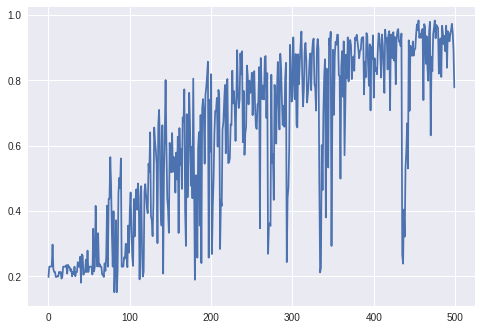

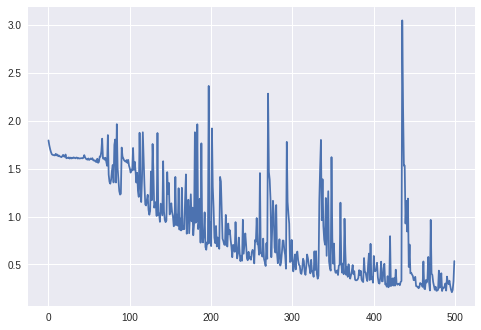

In [26]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
hsize = 128
input_size = 2
output_size = cuenta_hasta+1
red = simpleRNN(2, hsize, output_size)
optimizador = torch.optim.SGD(red.parameters(), lr=0.01)

train(red, data_count_train, data_count_test, optimizador, 5000)

## 2.3) Secuencias más largas

Repite el código de arriba,  pero ahora para intentar que la red resuelva problemas para secuencias de un largo mayor a las anteriores. Elige uno de los  Data Loaders de arriba (puede ser el mismo anterior, pero prueba los otros  también). Prueba varios casos y deja el caso de strings lo más largo posible en donde la red alcanzó a aprender, y otro caso en donde la red no puede aprender incluso cuándo la entrenas por muchas iteraciones. Prueba también cambiando hiperparámetros como la cantidad de neuronas o el tamaño del batch (este puede ser muy importante para algunos datos!)  y chequea si mejora el aprendizaje.

4990 Acc-test: 0.46 Loss-test: 1.2208276987075806
Tiempo total:139.346s


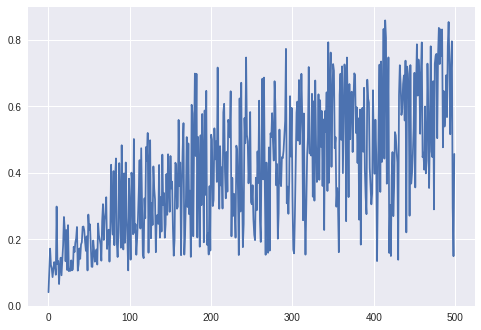

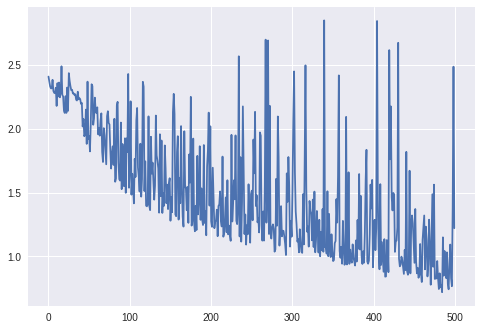

In [31]:
# acá tu código para un caso de secuencias largas en donde la red aprende
# (deja los gráficos del accuracy y loss en el test)
max_unos = 10
min_length = 30
max_length = 35
cuenta_hasta = 10
batch_size = 8

data_count_train = CountDataLoader(max_unos = max_unos,
                                   min_length = min_length,
                                   max_length = max_length,
                                   cuenta_hasta = cuenta_hasta,
                                   fixed = False,
                                   batch_size = batch_size
                                  )

## Creamos un conjunto de prueba fijo con 5000 ejemplos de largo 23
test_length = 33
test_size = 5000

data_count_test = CountDataLoader(max_unos = max_unos,
                                  min_length = test_length,
                                  max_length = test_length,
                                  cuenta_hasta = cuenta_hasta,
                                  fixed = True,
                                  n_examples = test_size
                                 )

torch.set_default_tensor_type('torch.cuda.FloatTensor')
hsize = 128
input_size = 2
output_size = cuenta_hasta+1
red = simpleRNN(2, hsize, output_size)
optimizador = torch.optim.SGD(red.parameters(), lr=0.01)

train(red, data_count_train, data_count_test, optimizador, 5000)

4990 Acc-test: 0.05 Loss-test: 2.9520463943481445
Tiempo total:265.523s


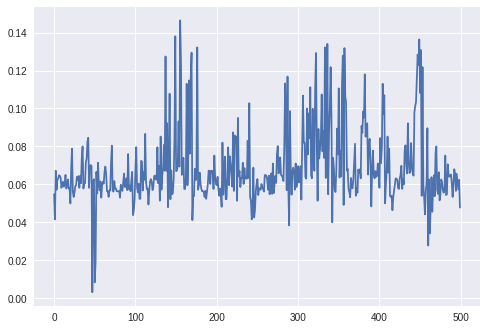

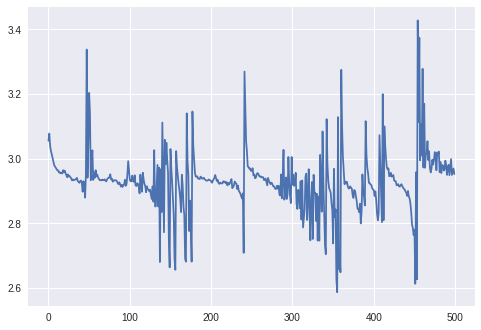

In [30]:
# acá tu código para un caso de secuencias suficientemente largas en donde
# la red no es capaz de aprender
max_unos = 20
min_length = 60
max_length = 70
cuenta_hasta = 20
batch_size = 8

data_count_train = CountDataLoader(max_unos = max_unos,
                                   min_length = min_length,
                                   max_length = max_length,
                                   cuenta_hasta = cuenta_hasta,
                                   fixed = False,
                                   batch_size = batch_size
                                  )

## Creamos un conjunto de prueba fijo con 5000 ejemplos de largo 23
test_length = 65
test_size = 5000

data_count_test = CountDataLoader(max_unos = max_unos,
                                  min_length = test_length,
                                  max_length = test_length,
                                  cuenta_hasta = cuenta_hasta,
                                  fixed = True,
                                  n_examples = test_size
                                 )

torch.set_default_tensor_type('torch.cuda.FloatTensor')
hsize = 128
input_size = 2
output_size = cuenta_hasta+1
red = simpleRNN(2, hsize, output_size)
optimizador = torch.optim.SGD(red.parameters(), lr=0.01)

train(red, data_count_train, data_count_test, optimizador, 5000)

# Parte 3: Agregando capas y bidireccionalidad (OPCIONAL)

Repite la parte 2 pero creando ahora una clase `RNN` que defina una red recurrente simple ya sea con una capa adicional, o con bidireccionalidad. **Esta parte es opcional**  así que puedes elegir una de las dos adiciones, y te daremos puntaje adicional en tu tarea (no es necesario que programes ambas para obtener la bonificación). Recuerda que las ecuaciones para una RNN de dos capas son:

\begin{eqnarray}
h^{(1)\langle  t\rangle}  & = & \tanh( x^{\langle t\rangle}U^{(1)} + h^{(1)\langle t-1\rangle}V^{(1)} + b^{(1)}) \\
h^{(2)\langle  t\rangle}  & = & \tanh( h^{(1)\langle t\rangle}U^{(2)} + h^{(2)\langle t-1\rangle}V^{(2)} + b^{(2)}) \\
\hat{y} & = & \text{softmax}(h^{(2)\langle N\rangle}O + c)
\end{eqnarray}

Para el caso de una red bidireccional puede usar las ecuaciones:
\begin{eqnarray}
\vec{h}^{\langle  t\rangle}  & = & \tanh( x^{\langle t\rangle}U^{(1)} + \vec{h}^{\langle t-1\rangle}V^{(1)} + b^{(1)}) \\
\overleftarrow{h}^{\langle  t\rangle}  & = & \tanh( x^{\langle t\rangle}U^{(2)} + \overleftarrow{h}^{\langle t+1\rangle}V^{(2)} + b^{(2)}) \\
\hat{y} & = & \text{softmax}(\vec{h}^{\langle N\rangle}O^{(1)} + \overleftarrow{h}^{\langle 1\rangle}O^{(2)} + c)
\end{eqnarray}

(note que se está usando el extremo derecho de la pasada $\rightarrow$ y el extremo izquierdo de la pasada $\leftarrow$ para hacer la predicción).

Puede usar el código `SimpleRNN` anterior como base

In [0]:
class RNN(torch.nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # crea acá los parámetros de tu red
        #####################################################
        # acá tu código (no debieran ser más de 10 líneas!!!)

        # acá termina tu código
        #####################################################

        self.reset_parameters()

    def reset_parameters(self):
        # resetea acá los parámetros de tu red
        #####################################################
        # acá tu código (no debieran ser más de 10 líneas!!!)

        # acá termina tu código
        #####################################################
        pass

    def forward(self, x):
        N, B, f = x.size()

        ####################################################
        # acá tu código para entrenar 
        # (no debieran ser más de 10 líneas!!!)
        # recuerda hacer el cálculo de y_pred al final

        # acá termina tu código
        ####################################################

        return y_pred

In [0]:
## Puedes entrenar tu nueva RNN con los mismos datos que antes
## o generar nuevos datos de entrenamiento
## Tu código acá

# Parte 4: Redes de Compuertas

En esta parte programarás y probarás las Gated Recurrent Units. También la podrás comparar con las RNN simples.

## 3.1) Gated Recurrent Units

En esta parte sólo tienes que modificar el código de tu red inicial `SimpleRNN` para que implementen las funciones de recurrencia de las GRU.  Recuerda que estas funciones son muy similares a las de una RNN normal, más dos "compuertas" (que llamaremos $\gamma$ y $\rho$). En específico las fórmulas que debes programar son las siguientes (donde $*$ es el producto componente a componente):

\begin{eqnarray}
\rho^{\langle  t\rangle}  & = & \sigma( x^{\langle t\rangle}U_{\rho} + h^{\langle t-1\rangle}V_{\rho} + b_{\rho}) \\
\gamma^{\langle  t\rangle}  & = & \sigma( x^{\langle t\rangle}U_{\gamma} + h^{\langle t-1\rangle}V_{\gamma} + b_{\gamma}) \\
\tilde{h}^{\langle  t\rangle}  & = & \tanh( x^{\langle t\rangle}U + \rho^{\langle  t\rangle}*h^{\langle t-1\rangle}V + b) \\
{h}^{\langle  t\rangle}  & = & \gamma^{\langle  t\rangle}*\tilde{h}^{\langle  t\rangle} + (1-\gamma^{\langle  t\rangle})*h^{\langle t-1\rangle}\\
\hat{y} & = & \text{softmax}(h^{\langle N\rangle}O + c)
\end{eqnarray}


In [0]:
class GRU(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # crea acá los parámetros de tu red
        self.U = Parameter(torch.Tensor(input_size, hidden_size))
        self.V = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b = Parameter(torch.Tensor(hidden_size))
        self.U_p = Parameter(torch.Tensor(input_size, hidden_size))
        self.V_p = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_p = Parameter(torch.Tensor(hidden_size))
        self.U_g = Parameter(torch.Tensor(input_size, hidden_size))
        self.V_g = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_g = Parameter(torch.Tensor(hidden_size))
        self.final_fc = torch.nn.Linear(hidden_size, output_size)
        self.reset_parameters()

    def reset_parameters(self):
        # resetea acá los parámetros de tu red
        self.final_fc.reset_parameters()
        stdv = 1.0 / math.sqrt(self.hidden_size)
        self.U.data.normal_(std=stdv)
        self.V.data.normal_(std=stdv)
        self.b.data.fill_(0)
        self.U_p.data.normal_(std=stdv)
        self.V_p.data.normal_(std=stdv)
        self.b_p.data.fill_(0)
        self.U_g.data.normal_(std=stdv)
        self.V_g.data.normal_(std=stdv)
        self.b_g.data.fill_(0)

    def forward(self, x):
        N, B, f = x.size()
        # programa la pasada hacia adelante
        d = self.b.size()[0]
        h = torch.zeros(1, d)
        h_hat = torch.zeros(1, d)
        p = torch.zeros(1, d)
        g = torch.zeros(1, d)
        h = Variable(h, requires_grad = True)
        h_hat = Variable(h_hat, requires_grad = True)
        p = Variable(p, requires_grad = True)
        g = Variable(g, requires_grad = True)
        for i in range(N):
          p = sigmoid(x[i].mm(self.U_p) + h.mm(self.V_p) + self.b_p)
          g = sigmoid(x[i].mm(self.U_g) + h.mm(self.V_g) + self.b_g)
          h_hat = tanh(x[i].mm(self.U) + p * h.mm(self.V) + self.b)
          h = g * h_hat + (1 - g) * h
        y_pred = self.final_fc(h)
        return y_pred

## 4.2) Entrenando GRU

Acá simplemente repite lo mismo  que hiciste para `SimpleRNN` y entrena tu red con el Data Loader inicial para contar `1`s. Trata de usar los mismos ejemplos iniciales que te dieron buenos resultados para RNN.



4990 Acc-test: 0.96 Loss-test: 0.2465512752532959
Tiempo total:300.698s


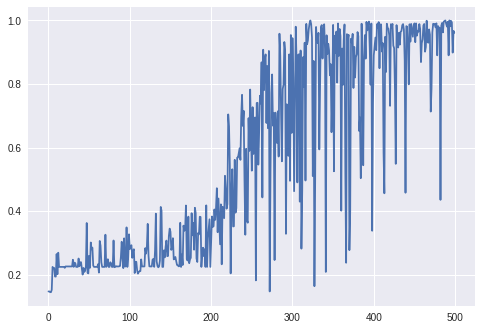

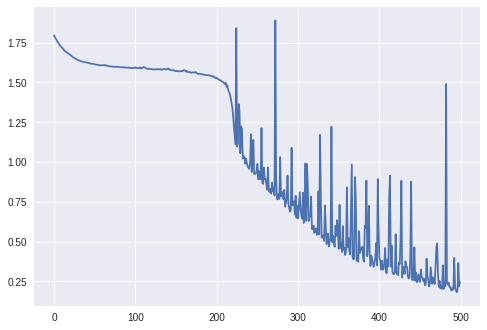

In [37]:
# acá tu código para entrenar 
# (recuerda que puedes usar los mismos datos creados para SimpleRNN)
max_unos = 5
min_length = 20
max_length = 25
cuenta_hasta = 5
batch_size = 8

data_count_train = CountDataLoader(max_unos = max_unos,
                                   min_length = min_length,
                                   max_length = max_length,
                                   cuenta_hasta = cuenta_hasta,
                                   fixed = False,
                                   batch_size = batch_size
                                  )

## Creamos un conjunto de prueba fijo con 5000 ejemplos de largo 23
test_length = 23
test_size = 5000

data_count_test = CountDataLoader(max_unos = max_unos,
                                  min_length = test_length,
                                  max_length = test_length,
                                  cuenta_hasta = cuenta_hasta,
                                  fixed = True,
                                  n_examples = test_size
                                 )

torch.set_default_tensor_type('torch.cuda.FloatTensor')
hsize = 128
input_size = 2
output_size = cuenta_hasta+1
red = GRU(2, hsize, output_size)
optimizador = torch.optim.SGD(red.parameters(), lr=0.01)

train(red, data_count_train, data_count_test, optimizador, 5000)

## 4.3) Comparando GRU y RNN simples

Busca un caso en donde GRU y RNN tengan comportamientos distintos y haz una comparación. Comenta acerca de lo que encontraste. Sólo debes generar datos con alguno de los generadores anteriores y ver las diferencias en el tiempo de convergencia (si es que convergen) y la certeza en las predicciones a las que llegan ambas arquitecturas.

6990 Acc-test: 0.14 Loss-test: 2.4244537353515625
Tiempo total:196.252s


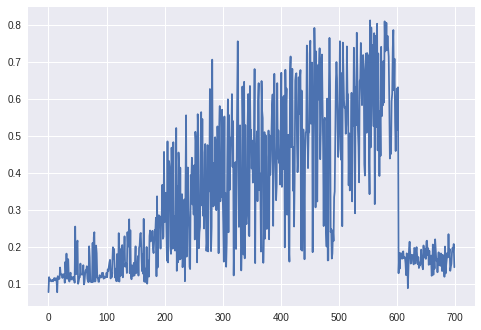

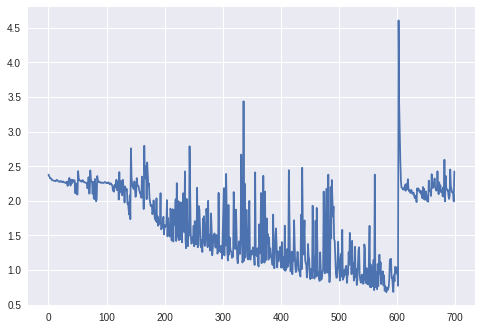

6990 Acc-test: 0.69 Loss-test: 0.677924633026123
Tiempo total:604.251s


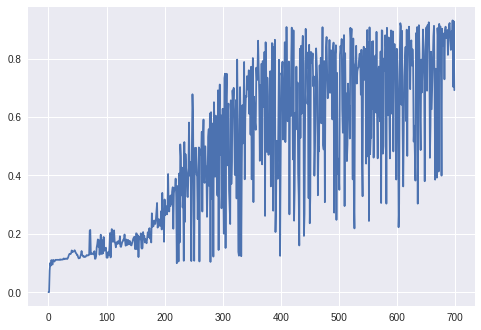

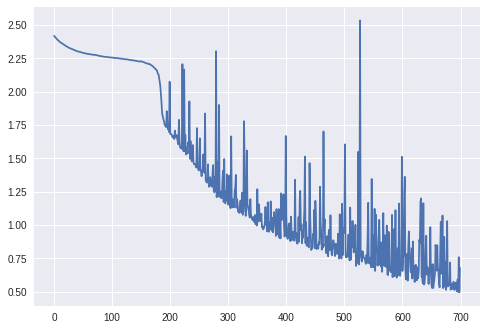

In [43]:
# acá tu código para entrenar RNN y GRU con los mismos generadores
max_unos = 10
min_length = 30
max_length = 35
cuenta_hasta = 10
batch_size = 8

data_count_train = CountDataLoader(max_unos = max_unos,
                                   min_length = min_length,
                                   max_length = max_length,
                                   cuenta_hasta = cuenta_hasta,
                                   fixed = False,
                                   batch_size = batch_size
                                  )

## Creamos un conjunto de prueba fijo con 5000 ejemplos de largo 23
test_length = 33
test_size = 5000

data_count_test = CountDataLoader(max_unos = max_unos,
                                  min_length = test_length,
                                  max_length = test_length,
                                  cuenta_hasta = cuenta_hasta,
                                  fixed = True,
                                  n_examples = test_size
                                 )

torch.set_default_tensor_type('torch.cuda.FloatTensor')
hsize = 128
input_size = 2
output_size = cuenta_hasta+1

# Simple RNN
red_1 = simpleRNN(2, hsize, output_size)
optimizador_1 = torch.optim.SGD(red_1.parameters(), lr=0.01)
train(red_1, data_count_train, data_count_test, optimizador_1, 7000) # 5k

# GRU RNN
red_2 = GRU(2, hsize, output_size)
optimizador_2 = torch.optim.SGD(red_2.parameters(), lr=0.01)
train(red_2, data_count_train, data_count_test, optimizador_2, 7000)

El caso presentado muestra una secuencia de largo intermedio de los probadas en los ejemplos anteriores, entrenando los modelos con secuencias de largos 30-35 y testeandolo los mismos con secuencias de largo 33.<br/>
Se aumentaron las iteraciones de entrenamiento a 7000 para observar la convergencia de los modelos.<br/>
Ambos modelos se entrenaron con la misma elección de hiperparámetros.


*   **Elmann RNN:** Se aprecia que el modelo presenta un rendimiento creciente en entrenamiento hasta alcanzar aproximadamente 65% de accuracy en la época 600, donde luego su desempeño se desploma por el sobreajuste, por lo cual, se infiere que se alcanzó la máxima capacidad del modelo con los hiperparámetros escogidos, siendo incapaz de ajustarse de mejor manera al problema propuesto.
*   **GRU RNN:** A diferencia del caso anterior, el modelo con memoria aumenta su rendimiento a lo largo de todas las épocas de entrenamiento probadas, alcanzando un accuracy aproximad de 90% en la época 700, observandose un comportamiento pseudo convergente. </br>

Se infiere que el modelo GRU tiene mayor capacidad para ajustarse a problemas más complejos (secuencias más largas) que el modelo simple, debido a que se comporta como una generalización del modelo RNN simple, teniendo todas las capaciades del mismo, adicionando la capacidad de memoria mediante compuertas, permitiendo que estados inciales puedan viajar íntegramente por la red, suprimiendo el sesgo natural de las redes Elmann RNN de despreciar la inejerencia de las secuencias iniciales. Si bien el modelo GRU tiene mayor capacidad que el modelo simple, el costo para ello es u aumento en el número de parametros (Matrices rho y gamma) y por ende, un aumento en los tiempos de entrenamiento por la complejización del backpropagation debido al aumento de parámetros entrenables. 



# Parte 5: Lo que quieras (OPCIONAL)

Ya tienes tu RNN y GRU. Ahora puedes generar  un  Data Loader similar a los que mostramos arriba con los datos que quieras. Por ejemplo, podrías descargar mucho texto y crear un set de datos de secuencias para entrenar a tu red para predecir la siguiente palabra dada una secuencia de palabras iniciales (o más simple podría ser que la entrenes para predecir el siguiente caracter). Una vez entrenada la red,  la puedes usar para generar texto a partir de pasarle un ejemplo inicial y luego de la predicción de la red, usar esa predicción para construir un nuevo ejemplo y pedirle  la predicción del siguiente  (mira los apuntes de clases!). Ojo, para que funcione relativamente bien necesitarás harto texto y  harto tiempo de entrenamiento.

Esta parte no la revisaremos, pero puede  ser muy entretenida de completar :-)